In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle
import imageio
import cv2
import mediapipe as mp


In [ ]:

# Initialize Mediapipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5)

# Function to process a single video
def process_video(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    
    # Get video properties
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    vid_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    vid_name = os.path.basename(video_path)
    
    # Initialize data storage
    feat = []

    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the frame to RGB as required by Mediapipe
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Pose estimation
        results = pose.process(frame_rgb)

        # If landmarks detected
        if results.pose_landmarks:
            frame_data = []
            for landmark in results.pose_landmarks.landmark:
                # x, y, z coordinates and visibility
                frame_data.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
            feat.append(frame_data)
        else:
            # If no landmarks found, append empty data
            feat.append([[0, 0, 0, 0]] * 543)  # Empty landmarks (543,4)
        
        frame_count += 1

    cap.release()

    # Store data in a dictionary
    video_data = {
        'feat': feat,  # Features (no. of frames, 543, 4)
        'num_frames': num_frames,  # Total number of frames
        'vid_name': vid_name,  # Name of the video
        'vid_width': vid_width,  # Width of the video
        'vid_height': vid_height  # Height of the video
    }

    # Save the data to a pickle file
    output_path = os.path.join(output_dir, f"{os.path.splitext(vid_name)[0]}.pkl")
    with open(output_path, 'wb') as f:
        pickle.dump(video_data, f)

    print(f"Processed video saved to {output_path}")

# Main function to process all videos in a folder
def process_videos_in_folder(folder_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for video_file in os.listdir(folder_path):
        if video_file.endswith(('.mp4', '.avi', '.mkv')):  # Modify as per video formats
            video_path = os.path.join(folder_path, video_file)
            print(f"Processing {video_file}...")
            process_video(video_path, output_dir)

# Specify input folder containing videos and output directory for pickle files
input_folder = "path_to_video_folder"  # Change this to your folder containing videos
output_folder = "path_to_output_folder"  # Change this to where you want to save pickle files

process_videos_in_folder(input_folder, output_folder)


In [1]:
import os
import pickle
import pandas as pd

# Tryout -----------------------------------------

In [36]:
with open('0_D2t46WwwY--46.pkl', 'rb') as file:
    data = pickle.load(file)

In [71]:
print(data.keys())
print("keypoints shape:",data['keypoints'].shape)
print("confidences shape:",data['confidences'].shape)

dict_keys(['keypoints', 'confidences'])
keypoints shape: (222, 75, 3)
confidences shape: (222, 75)


In [40]:
# there are 75 landamrks: first 33 for Pose, next 21,21 for left-right hands

frame_idx = 5

left_hand_indices = list(range(33, 54))   # Left hand landmarks
right_hand_indices = list(range(54, 75))  # Right hand landmarks
pose_indices = list(range(21))  # First 21 pose landmarks

# Combine the indices
selected_indices = pose_indices + left_hand_indices + right_hand_indices


def select_landmarks(features, frame_idx, selected_indices):
    frame_data = features[frame_idx, :, :]                      # Extract the frame data
    selected_landmarks = frame_data[selected_indices, :]        # Select specific landmarks

    return selected_landmarks

# Get the selected landmarks for the specified frame
selected_landmarks = select_landmarks(data['keypoints'], frame_idx, selected_indices)

# first 21 pose, left hand, and right hand with shape 
# (63, 4), where 63 = 21 (pose) + 21 (left hand) + 21 (right hand)
print(len(selected_landmarks))


63


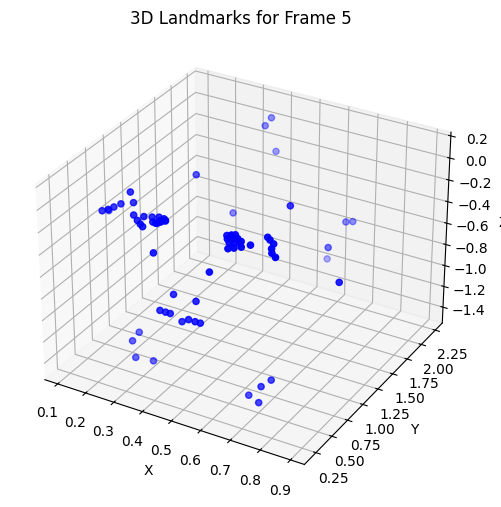

In [52]:
def plot_landmarks(features, frame_idx):
    frame_data = features[frame_idx, :, :]  # Extract the data for the specified frame

    x = frame_data[:, 0]  # X-coordinates
    y = frame_data[:, 1]  # Y-coordinates
    z = frame_data[:, 2]  # Z-coordinates
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x, y, z, c='b', marker='o')

    # Annotate points with indices
    #for i in range(len(x)):
    #    ax.text(x[i], y[i], z[i], str(i), size=8, color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'3D Landmarks for Frame {frame_idx}')
    plt.show()

# Call the function to plot
plot_landmarks(data['keypoints'], frame_idx)


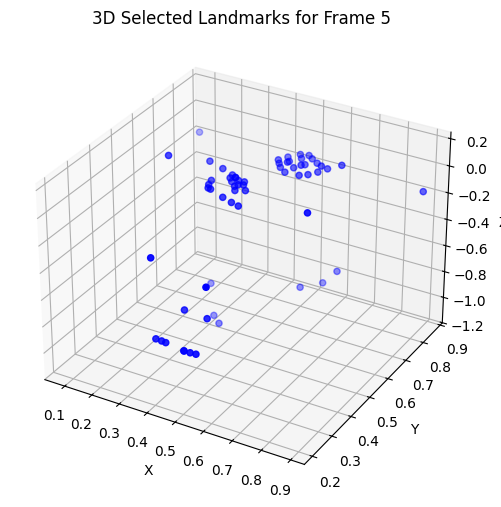

In [53]:
def plot_selected_landmarks(selected_landmarks, frame_idx):
    x = selected_landmarks[:, 0]  
    y = selected_landmarks[:, 1]  
    z = selected_landmarks[:, 2]  
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the selected landmarks
    ax.scatter(x, y, z, c='b', marker='o')

    # Annotate points with indices (within the selected landmarks only)
    #for i in range(len(x)):
    #    ax.text(x[i], y[i], z[i], str(i), size=8, color='red')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'3D Selected Landmarks for Frame {frame_idx}')
    plt.show()

# Plot the selected landmarks for the specific frame
plot_selected_landmarks(selected_landmarks, frame_idx)

In [54]:
# Define landmark connections for pose, left hand, and right hand (based on MediaPipe skeleton)
pose_connections = [(0, 1), (1, 2), (2, 3), (3, 7), (0, 4), (4, 5), (5, 6), (6, 8),
                    (9, 10), (11, 12), (12, 14), (14, 16), (16, 20), (11, 13), (13, 15),
                    (15, 19), (23, 24), (24, 26), (26, 28), (28, 30), (30, 32), (23, 25),
                    (25, 27), (27, 29), (29, 31)]
hand_connections = [(0, 1), (1, 2), (2, 3), (3, 4),   # Thumb
                    (0, 5), (5, 6), (6, 7), (7, 8),   # Index
                    (0, 9), (9, 10), (10, 11), (11, 12),   # Middle
                    (0, 13), (13, 14), (14, 15), (15, 16), # Ring
                    (0, 17), (17, 18), (18, 19), (19, 20)] # Pinky

In [55]:
# The selected indices for pose + hands landmarks in our feature set (already defined)
pose_indices = list(range(21))  # First 21 for pose
left_hand_indices = list(range(21, 42))  # Next 21 for left hand
right_hand_indices = list(range(42, 63))  # Last 21 for right hand

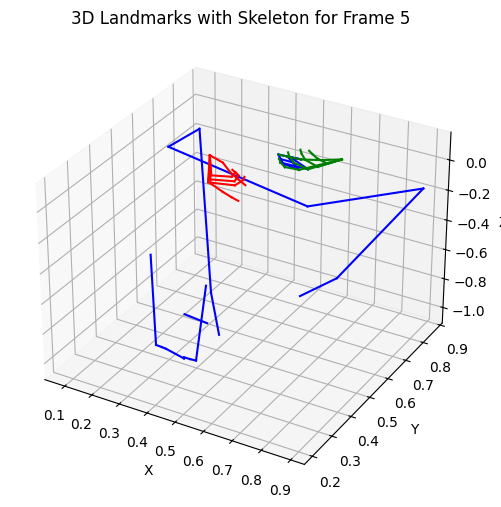

In [56]:
# Function to plot 3D skeleton
def plot_3d_skeleton(selected_landmarks, frame_idx):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot pose landmarks
    for connection in pose_connections:
        start, end = connection
        ax.plot([selected_landmarks[start, 0], selected_landmarks[end, 0]],
                [selected_landmarks[start, 1], selected_landmarks[end, 1]],
                [selected_landmarks[start, 2], selected_landmarks[end, 2]], 'b-')

    # Plot left hand landmarks
    for connection in hand_connections:
        start, end = connection
        ax.plot([selected_landmarks[21 + start, 0], selected_landmarks[21 + end, 0]],
                [selected_landmarks[21 + start, 1], selected_landmarks[21 + end, 1]],
                [selected_landmarks[21 + start, 2], selected_landmarks[21 + end, 2]], 'g-')

    # Plot right hand landmarks
    for connection in hand_connections:
        start, end = connection
        ax.plot([selected_landmarks[42 + start, 0], selected_landmarks[42 + end, 0]],
                [selected_landmarks[42 + start, 1], selected_landmarks[42 + end, 1]],
                [selected_landmarks[42 + start, 2], selected_landmarks[42 + end, 2]], 'r-')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.title(f'3D Landmarks with Skeleton for Frame {frame_idx}')
    plt.show()

plot_3d_skeleton(selected_landmarks, frame_idx)

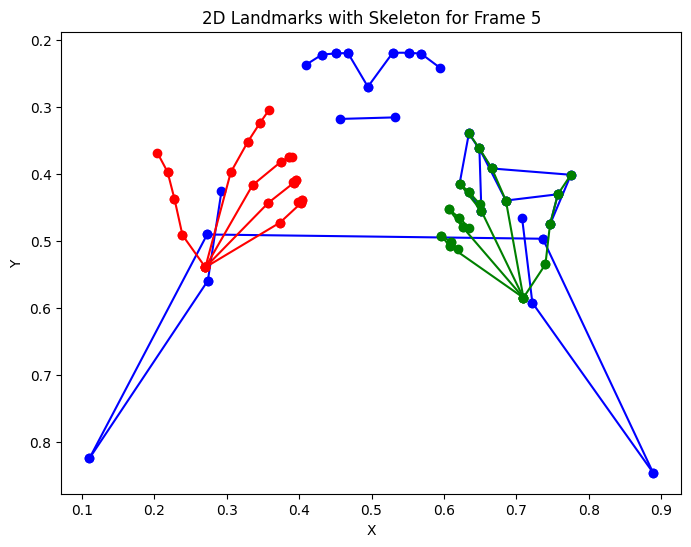

In [44]:
# Function to plot 2D skeleton
def plot_2d_skeleton(selected_landmarks, frame_idx):
    plt.figure(figsize=(8, 6))

    # Plot pose landmarks
    for connection in pose_connections:
        start, end = connection
        plt.plot([selected_landmarks[start, 0], selected_landmarks[end, 0]],
                 [selected_landmarks[start, 1], selected_landmarks[end, 1]], 'b-', marker='o')

    # Plot left hand landmarks
    for connection in hand_connections:
        start, end = connection
        plt.plot([selected_landmarks[21 + start, 0], selected_landmarks[21 + end, 0]],
                 [selected_landmarks[21 + start, 1], selected_landmarks[21 + end, 1]], 'g-', marker='o')

    # Plot right hand landmarks
    for connection in hand_connections:
        start, end = connection
        plt.plot([selected_landmarks[42 + start, 0], selected_landmarks[42 + end, 0]],
                 [selected_landmarks[42 + start, 1], selected_landmarks[42 + end, 1]], 'r-', marker='o')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'2D Landmarks with Skeleton for Frame {frame_idx}')
    plt.gca().invert_yaxis()  # Invert Y-axis for correct orientation
    plt.show()

plot_2d_skeleton(selected_landmarks, frame_idx)

## Motion Pictures

In [45]:
# Ensure the output directory exists
output_dir = "motion_frames"
os.makedirs(output_dir, exist_ok=True)

# Function to plot 2D skeleton and save each frame as an image
def plot_2d_skeleton(selected_landmarks, frame_idx):
    plt.figure(figsize=(4, 3))

    # Plot pose landmarks
    for connection in pose_connections:
        start, end = connection
        plt.plot([selected_landmarks[start, 0], selected_landmarks[end, 0]],
                 [selected_landmarks[start, 1], selected_landmarks[end, 1]], 'b-', marker='o')

    # Plot left hand landmarks
    for connection in hand_connections:
        start, end = connection
        plt.plot([selected_landmarks[21 + start, 0], selected_landmarks[21 + end, 0]],
                 [selected_landmarks[21 + start, 1], selected_landmarks[21 + end, 1]], 'g-', marker='o')

    # Plot right hand landmarks
    for connection in hand_connections:
        start, end = connection
        plt.plot([selected_landmarks[42 + start, 0], selected_landmarks[42 + end, 0]],
                 [selected_landmarks[42 + start, 1], selected_landmarks[42 + end, 1]], 'r-', marker='o')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'2D Landmarks with Skeleton for Frame {frame_idx}')
    plt.gca().invert_yaxis()  # Invert Y-axis for correct orientation
    
    # Save the figure as an image
    frame_filename = os.path.join(output_dir, f"frame_{frame_idx:03d}.png")
    plt.savefig(frame_filename)
    plt.close()  # Close the plot to free up memory

# Loop through frames and plot
frames = list(range(0, len(data['keypoints'])))
for i in frames:
    selected_landmarks = select_landmarks(data['keypoints'], i, selected_indices)
    plot_2d_skeleton(selected_landmarks, i)

print(f"Frames saved in '{output_dir}' directory.")


Frames saved in 'motion_frames' directory.


In [72]:
def get_fps(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return None

    # Get FPS
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Release the video capture object
    cap.release()

    return fps

# Example usage
video_path1 = '0_D2t46WwwY--46.mp4'  # Replace with your video file path
fps = get_fps(video_path1)

if fps is not None:
    print(f"FPS of signer video: {fps}")


FPS of signer video: 29.97


In [73]:
output_dir = "motion_frames"
frame_files = [os.path.join(output_dir, f"frame_{i:03d}.png") for i in frames]

# Save frames as an MP4 video
with imageio.get_writer('motion_picture.mp4', fps=29.97, codec='libx264') as writer:
    for frame_file in frame_files:
        image = imageio.imread(frame_file)
        writer.append_data(image)

print("MP4 video saved as 'motion_picture.mp4'")

/tmp/ipykernel_277149/1455506656.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_file)
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (400, 300) to (400, 304) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


MP4 video saved as 'motion_picture.mp4'


sentece for 0_D2t46WwwY--46.mp4 is:
### any athlete who is facing any kind of trouble should contact SAI.

## Get static images of sign person

In [57]:
# Path to the input video file
video_path = '0_D2t46WwwY--46.mp4'

# Directory to save the output frames
output_dir = 'video_frames'
os.makedirs(output_dir, exist_ok=True)

# Load the video using OpenCV
cap = cv2.VideoCapture(video_path)

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Target number of frames to extract (222 frames in your case)
target_frames = 222

# Calculate the interval at which to extract frames to get 222 frames
interval = total_frames // target_frames

frame_count = 0
saved_frames = 0

while saved_frames < target_frames:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Save frame at the calculated interval
    if frame_count % interval == 0:
        frame_filename = os.path.join(output_dir, f"frame_{saved_frames:03d}.png")
        cv2.imwrite(frame_filename, frame)
        saved_frames += 1
    
    frame_count += 1

cap.release()
print(f"Saved {saved_frames} frames in {output_dir}")


Saved 222 frames in video_frames


## Impose landmarks on static images

In [60]:
# Directories for input frames and output directory for final overlayed frames
video_frames_dir = 'video_frames'
motion_frames_dir = 'motion_frames'
output_dir = 'overlayed_frames'
os.makedirs(output_dir, exist_ok=True)

# Function to remove the white background of motion frames (landmark plots)
def remove_white_background(image):
    # Convert the image to grayscale to create a mask
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a mask where the white parts are set to 0 (transparent) and other areas to 255
    _, mask = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY_INV)

    # Convert the mask to 3 channels
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)

    # Remove the white background
    result = cv2.bitwise_and(image, mask)
    return result

# Function to fade the video frame
def fade_video_frame(image, alpha=0.6):
    return cv2.addWeighted(image, alpha, np.zeros_like(image), 1 - alpha, 0)

# Function to resize the images so they have the same dimensions
def resize_to_match(frame1, frame2):
    h1, w1 = frame1.shape[:2]
    h2, w2 = frame2.shape[:2]
    
    if h1 != h2 or w1 != w2:
        frame2 = cv2.resize(frame2, (w1, h1))
    
    return frame2

# Process each frame
for frame_num in range(222):
    # Load the video frame
    video_frame_path = os.path.join(video_frames_dir, f"frame_{frame_num:03d}.png")
    video_frame = cv2.imread(video_frame_path)

    # Load the motion (landmark) frame
    motion_frame_path = os.path.join(motion_frames_dir, f"frame_{frame_num:03d}.png")
    motion_frame = cv2.imread(motion_frame_path)

    if video_frame is None or motion_frame is None:
        print(f"Error loading frame {frame_num}")
        continue

    # Remove the white background from the motion frame
    motion_frame_transparent = remove_white_background(motion_frame)

    # Fade out the video frame
    faded_video_frame = fade_video_frame(video_frame)

    # Resize motion frame to match video frame if necessary
    motion_frame_resized = resize_to_match(faded_video_frame, motion_frame_transparent)

    # Overlay the motion (landmark) frame on the video frame
    overlayed_frame = cv2.add(faded_video_frame, motion_frame_resized)

    # Save the final overlayed frame
    output_frame_path = os.path.join(output_dir, f"overlayed_frame_{frame_num:03d}.png")
    cv2.imwrite(output_frame_path, overlayed_frame)

print(f"Overlayed frames saved in {output_dir}")


Overlayed frames saved in overlayed_frames


In [63]:
# List the saved frame images
output_dir = 'overlayed_frames'
frame_files = [os.path.join(output_dir, f"overlayed_frame_{i:03d}.png") for i in frames]

# Save frames as a GIF
with imageio.get_writer('signer_motion_picture.gif', mode='I', duration=0.001) as writer:
    for frame_file in frame_files:
        image = imageio.imread(frame_file)
        writer.append_data(image)

print("GIF saved as 'signer_motion_picture.gif'")

/tmp/ipykernel_277149/3444100638.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(frame_file)


GIF saved as 'signer_motion_picture.gif'
